In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
#/content/drive/MyDrive/Sandal_Boot.zip
!ls /content/drive/MyDrive/Sandal_Boot.zip
!unzip -q /content/drive/MyDrive/Sandal_Boot.zip

/content/drive/MyDrive/Sandal_Boot.zip


The data used is a strip down version of this dataset here: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images?rvi=1

In [3]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import random
from skimage.transform import resize 
from keras import utils 
from scipy.ndimage import rotate
import gc

from sklearn.metrics import confusion_matrix 


In [4]:
path =  r'/content/Shoe vs Sandal vs Boot Dataset'
target_w, target_h= 136, 102
test_ratio, validation_ratio=0.2, 0.2

label, X, y =[], [], []
for dir in [f.path for f in os.scandir(path) if f.is_dir()]:
  label.append(dir.split('/')[-1]) #chỉ lấy tên file, không cần lấy tên directory
  for file in next(os.walk(dir), (None, None, []))[2]:
    if file != ".ipynb_checkpoints":
        file_path = os.path.join(dir, file)
        img = cv2.imread(file_path)
        img_array = np.asarray(img)
        X.append(img_array)
        y.append(dir.split('/')[-1])



In [5]:
y_out = []
for i, val in enumerate(y):
  y_out.append(label.index(val))

y = y_out.copy()


In [32]:
print(label)

['Boot', 'Sandal']


In [6]:
#shuffle data
X_y = list(zip(X, y))
random.shuffle(X_y)
X, y = zip(*X_y)

n_samples = len(X)
n_test= int(n_samples * test_ratio)
n_validation = int(n_samples * validation_ratio)

#split data into 3 set
X_test, y_test= X[:n_test], y[:n_test]
X_val, y_val = X[n_test: n_test + n_validation], y[n_test: n_test + n_validation]
X_train, y_train = X[n_test+n_validation:], y[n_test+n_validation:]

n_train = len(X_train)

In [7]:
#resize image to standard size
X_train = [resize(img, (target_w, target_h), anti_aliasing=True ) for img in X_train]
X_val = [resize(img, (target_w, target_h), anti_aliasing=True ) for img in X_val]
X_test = [resize(img, (target_w, target_h), anti_aliasing=True ) for img in X_test]

#convert everything to numpy array
combine=[X_train, y_train, X_val, y_val, X_test, y_test]
X_train, y_train, X_val, y_val, X_test, y_test = [np.asarray(ele) for ele in combine]


In [8]:
num_classes= len(label)

#one-hot encode
Y_train = utils.to_categorical(y_train, num_classes)
Y_val = utils.to_categorical(y_val, num_classes)
Y_test = utils.to_categorical(y_test, num_classes)

for i in range(10):
  print("Label: ", y_train[i]," Encode:",Y_train[i])

Label:  1  Encode: [0. 1.]
Label:  0  Encode: [1. 0.]
Label:  1  Encode: [0. 1.]
Label:  0  Encode: [1. 0.]
Label:  0  Encode: [1. 0.]
Label:  1  Encode: [0. 1.]
Label:  0  Encode: [1. 0.]
Label:  0  Encode: [1. 0.]
Label:  1  Encode: [0. 1.]
Label:  1  Encode: [0. 1.]


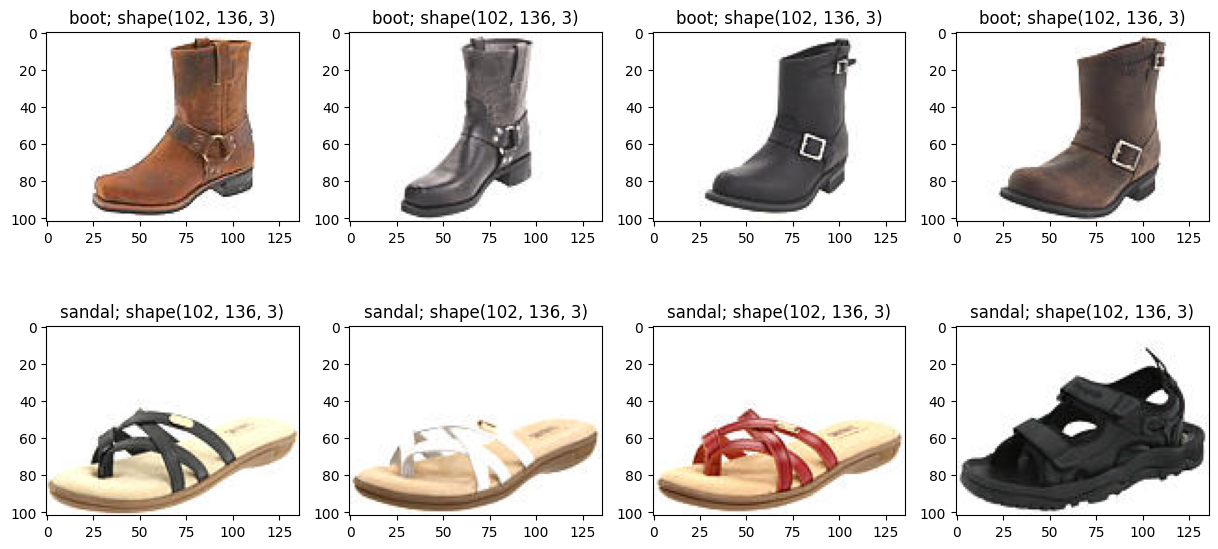

In [11]:
import matplotlib.image as mpimg
plt.figure(figsize=(15,7))
for i in range(1,5):
  plt.subplot(2,4,i)
  im1=mpimg.imread(path+'/Boot/boot ('+str(i)+').jpg')
  out1='boot; shape'+str(im1.shape)
  plt.title(out1)
  plt.imshow(im1)
for i in range(5,9):  
  plt.subplot(2,4,i)
  im2=mpimg.imread(path+'/Sandal/Sandal ('+str(i)+').jpg')
  out2='sandal; shape'+str(im2.shape)
  plt.title(out2)
  plt.imshow(im2)


In [14]:
import keras.layers as layers
from tensorflow import keras

model = keras.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', strides=(4,4),activation='relu', input_shape=(target_w, target_h, 3)))
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(200,activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy' , optimizer=keras.optimizers.SGD(learning_rate = 0.001) , metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 34, 26, 32)        2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 12, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 12, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 12, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 5, 128)        0         
 2D)                                                  

In [15]:
history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    validation_data=(X_val, Y_val)
)


Epoch 1/10
38/38 [==============================] - 17s 390ms/step - loss: 0.6867 - acc: 0.6142 - val_loss: 0.6828 - val_acc: 0.6750
Epoch 2/10
38/38 [==============================] - 14s 369ms/step - loss: 0.6800 - acc: 0.7075 - val_loss: 0.6772 - val_acc: 0.8125
Epoch 3/10
38/38 [==============================] - 14s 365ms/step - loss: 0.6742 - acc: 0.8350 - val_loss: 0.6716 - val_acc: 0.7950
Epoch 4/10
38/38 [==============================] - 15s 379ms/step - loss: 0.6681 - acc: 0.7800 - val_loss: 0.6656 - val_acc: 0.8900
Epoch 5/10
38/38 [==============================] - 14s 366ms/step - loss: 0.6620 - acc: 0.8950 - val_loss: 0.6595 - val_acc: 0.8625
Epoch 6/10
38/38 [==============================] - 14s 367ms/step - loss: 0.6552 - acc: 0.8625 - val_loss: 0.6521 - val_acc: 0.8775
Epoch 7/10
38/38 [==============================] - 15s 377ms/step - loss: 0.6468 - acc: 0.8983 - val_loss: 0.6435 - val_acc: 0.8800
Epoch 8/10
38/38 [==============================] - 14s 368ms/step - 

accuracy: 0.9525 
precison: 0.91981 
recall: 0.98985 
f-score: 0.95355


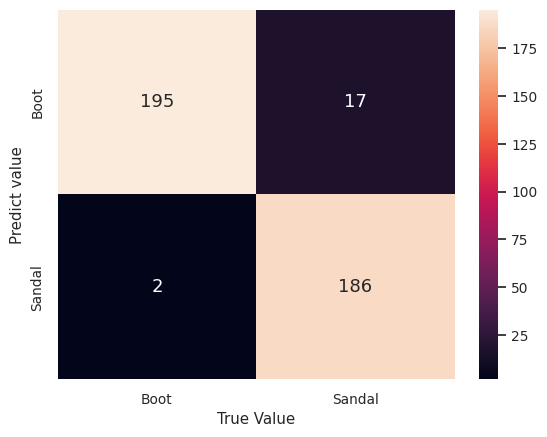

In [33]:
from sklearn.svm import SVC
import seaborn as sns

def evaluation(p,y):
    matrix=np.zeros((2,2))
    for i in range(len(y)):
        matrix[ round(p[i]) ] [y[i]]+=1
    #True+, True-, False+, False-    
    tp,tn,fp,fn=matrix[1,1], matrix[0,0], matrix[1,0], matrix[0,1]
    accuracy=round( (tp+tn)/ (tp+tn+fn+fp),5)
    precision= round(tp/ (tp+fp),5)
    recall= round(tp/(tp+fn),5)
    f_score= round(2*precision*recall/ (precision+recall),5)
    return accuracy,tp,tn,fp,fn, precision, recall, f_score

def Visualized_matrix(result):
  #plt.figure(figsize=(7,5))
  sns.set(font_scale=0.9)
  res=[ [result[1],result[3]] , [result[4],result[2]] ]
  ax=sns.heatmap(res,annot=True, annot_kws={"size": 13},fmt='g',
  xticklabels=['Boot','Sandal'],yticklabels=['Boot','Sandal']) 
  ax.set(xlabel='True Value',ylabel='Predict value') 

def the_result(result):
    print("accuracy:",result[0],"\nprecison:",result[5],"\nrecall:",result[6],"\nf-score:",result[7])

model.pop() #bỏ layer classification cuối cùng
feature_map=model(X_train) #dữ liệu qua model tạo thành feature map -> SVM
clf = SVC()
clf.fit(feature_map, y_train)

feature_map_val  = model(X_val)
prediction_val = clf.predict(feature_map_val)
result =  evaluation(prediction_val, y_val)
the_result(result)
Visualized_matrix(result)

accuracy: 0.9625 
precison: 0.94118 
recall: 0.98462 
f-score: 0.96241


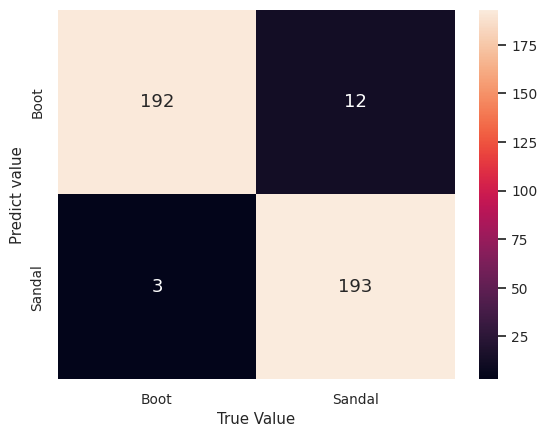

In [34]:
#how model predict on test set
feature_map_test  = model(X_test)
prediction_test = clf.predict(feature_map_test)
result =  evaluation(prediction_test, y_test)
the_result(result)
Visualized_matrix(result)

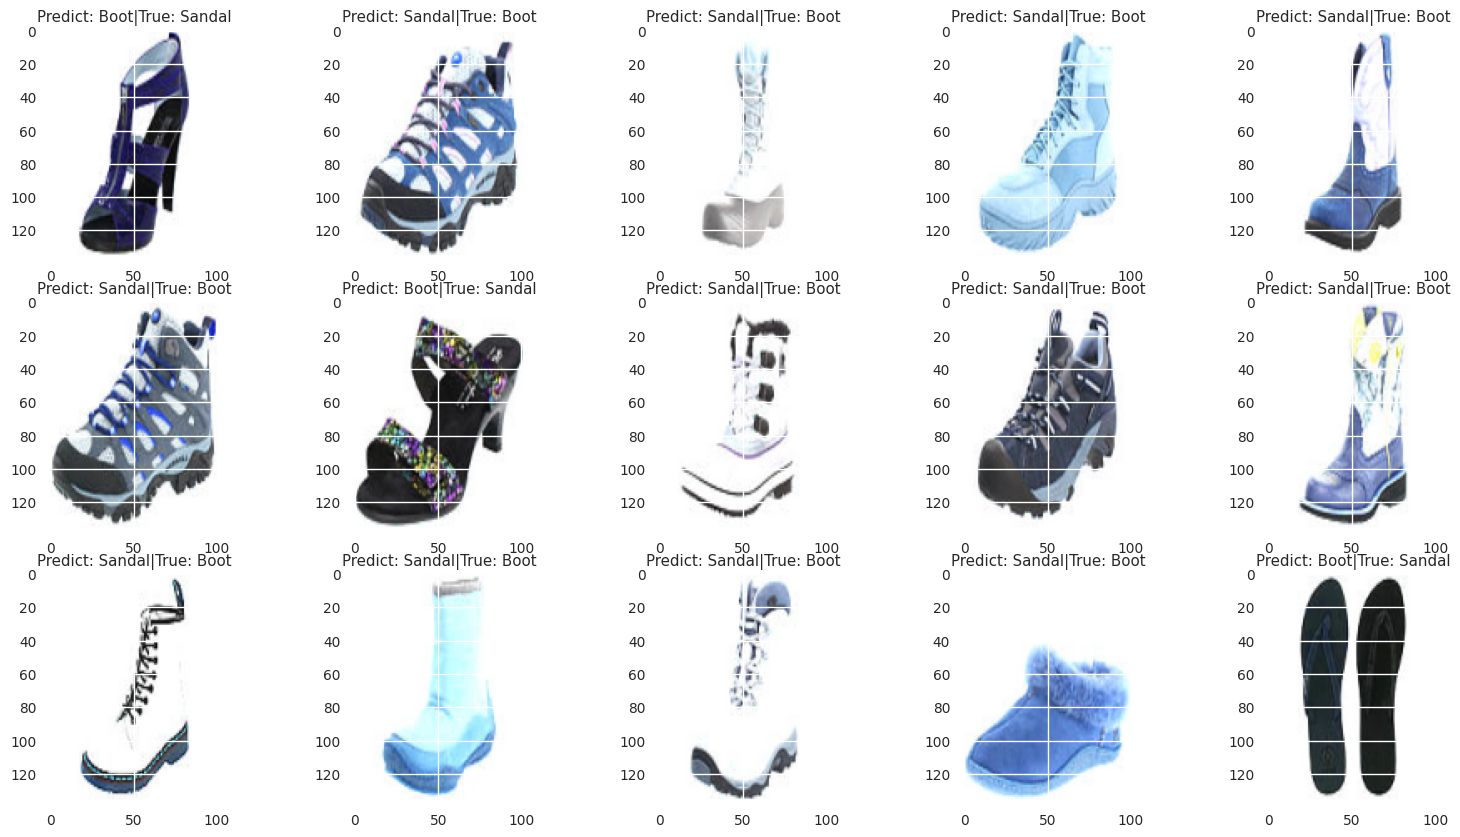

In [35]:
#view over the one that the model fail to predict to see what happen
fail=[]
for index, pred in enumerate(prediction_test):
  if pred != y_test[index]:
    fail.append(index)


dic={1:"Sandal", 0:"Boot"}
plt.figure(figsize=(19,10))
for index in range(15):
  plt.subplot(3,5,index+1)

  plt.imshow(X_test[fail[index]])
  out="Predict: "+str(dic[prediction_test[fail[index]]]) + "|True: "+ str(dic[y_test[fail[index]]])
  plt.title(out)

In [ ]:
plt.imshow(X_train[i])